In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from waterfall.WatermarkerBase import Watermarker
from waterfall.watermark import PROMPT, PRE_PARAPHRASED
import torch
from typing import List
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [3]:
watermarker = Watermarker(model = 'meta-llama/Meta-Llama-3.1-8B-Instruct', device="auto")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
T_o = "The boiling point of water is 100 degrees Celsius."
prompt = watermarker.format_prompt(T_o, PROMPT, PRE_PARAPHRASED)
input_ids = watermarker.tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=False)

In [5]:
def single_pass(input_ids, top_k = 4):
    with torch.no_grad():
        output = watermarker.model(
            input_ids = input_ids.to(watermarker.model.device),
            attention_mask = torch.ones_like(input_ids)
            ).cpu()
    return [(idx, prob) for prob, idx in zip(*torch.nn.functional.softmax(output.logits[...,-1,:].squeeze(), dim=-1).topk(k=top_k, dim=0))]

In [6]:
def expand(input_ids, remainder_tokens : int, top_k = 4) -> List:
    if remainder_tokens <= 0:
        return []
    res = []
    pass_results = single_pass(input_ids, top_k = top_k)
    for i, (idx, prob) in enumerate(pass_results):
        if prob <= 0.01:
            continue
        new_input_ids = torch.cat([input_ids.clone(), idx.view(1,1)], dim=-1)
        res.append((watermarker.tokenizer.decode(idx), prob.item(), expand(new_input_ids, remainder_tokens-1, top_k = top_k)))
    return res

In [7]:
def single_pass_(input_ids, top_k = 4):
    with torch.no_grad():
        output = watermarker.model(
            input_ids = input_ids.to(watermarker.model.device),
            attention_mask = torch.ones_like(input_ids)
            ).logits[...,-1,:].cpu()
    return [tuple(zip(idx, prob)) for prob, idx in zip(*torch.nn.functional.softmax(output, dim=-1).topk(k=top_k, dim=1))]

In [8]:
def expand_(input_ids, prev_results, remainder_tokens : int, top_k = 4, threshold = 0.01) -> List:
    if remainder_tokens <= 0:
        return []
    idxs = [i[0] for i in prev_results if i[1] > threshold]
    idxs = torch.stack(idxs)
    new_input_ids = torch.cat([input_ids.repeat(idxs.shape[0],1), idxs.unsqueeze(1)], dim=-1)
    pass_results = single_pass_(new_input_ids, top_k = top_k)
    res = []
    for (idx, prob), result, new_input_id in zip(prev_results, pass_results, new_input_ids):
        res.append((watermarker.tokenizer.decode(idx), prob.item(), expand_(new_input_id, result, remainder_tokens-1, top_k = top_k)))
    return res

In [9]:
expansion = expand_(input_ids[...,:-1], [(input_ids[0,-1], torch.tensor(1.0))], 5, top_k = 3, threshold = 0.05)

In [10]:
def compress_tree(node):
    """
    Recursively compress chains of single-child nodes.
    Rule: if node has exactly 1 child, concatenate keys,
    keep parent value, and recurse.
    """
    key, val, children = node

    # First compress children recursively
    compressed_children = [compress_tree(child) for child in children]

    # While there is exactly 1 child, merge into parent
    while len(compressed_children) == 1:
        child_key, child_val, child_children = compressed_children[0]
        key = key + child_key   # concat keys
        # value stays as parent's val
        compressed_children = child_children  # adopt child's children

    return (key, val, compressed_children)


In [11]:
# def build_graph(tree, G=None, parent=None, counter=[0]):
#     if G is None:
#         G = nx.DiGraph()
#     key, val, children = tree

#     # unique ID
#     node_id = counter[0]
#     counter[0] += 1

#     # label to display
#     label = f"{key}\n{val:.2f}" if val is not None else str(key)

#     G.add_node(node_id, label=label)

#     if parent is not None:
#         G.add_edge(parent, node_id)

#     for child in children:
#         build_graph(child, G, node_id, counter)

#     return G, node_id  # return both graph and root node id


# def hierarchy_pos(G, root, width=1.0, xcenter=0, pos=None, level=0):
#     """Recursive left-to-right hierarchical layout."""
#     if pos is None:
#         pos = {}
#     children = list(G.successors(root))
#     if not children:
#         pos[root] = (level, xcenter)
#     else:
#         dx = width / len(children)
#         nextx = xcenter - width/2 - dx/2
#         pos[root] = (level, xcenter)
#         for child in children[::-1]:
#             nextx += dx
#             pos = hierarchy_pos(G, child, width=dx, 
#                                 xcenter=nextx, pos=pos, level=level+1)
#     return pos

# # tree = ("root", None, expansion)
# tree = expansion[0]
# # Build graph and get root node
# # G, root = build_graph(tree)
# tree = compress_tree(tree)
# G, root = build_graph(tree)

# # Layout positions
# pos = hierarchy_pos(G, root)

# # Get labels from node attributes
# labels = nx.get_node_attributes(G, "label")

# # Draw
# plt.figure(figsize=(8,100))
# nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000, 
#         node_color="lightblue", arrows=True, font_size=10, font_weight="bold")
# plt.show()


In [12]:
from token_tree_generator import TokenDecode, convert_to_node, m, c
node_tree = convert_to_node(expansion[0])

In [13]:
from manim import Text, UP, DOWN, LEFT, RIGHT
import numpy as np
import matplotlib.pyplot as plt

-0.012892119897959181 -0.9999984801020411


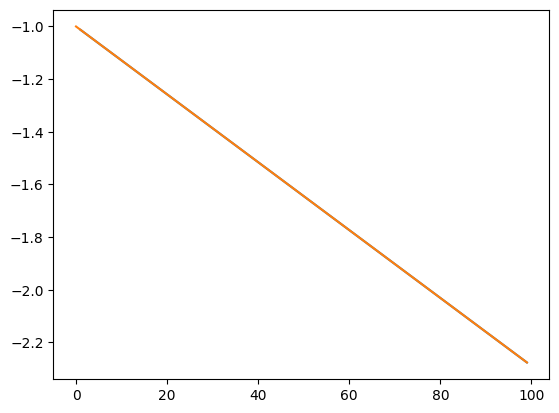

In [14]:
tmp = []
for i in range(1,100):
    a = Text("A", font_size=i, should_center=False)
    tmp.append(a.get_bottom()[1])
m = (tmp[-1] - tmp[0])/(len(tmp)-1)
c = tmp[0] - m
print(m, c)
# c = -20
plt.plot(np.arange(1,100), tmp)
plt.plot(np.arange(100), m * np.arange(100) + c)

In [15]:
font_size = 24
a = Text("a", font_size=font_size, should_center=False)
y_offset = (m * font_size + c - a.get_center()[1])
# y_offset = m * font_size + c
a.next_to(np.array([1, 2, 0]), RIGHT, buff=0.2)
a.shift(DOWN * (y_offset))
print("___")
b = Text("Boiling", font_size=font_size, should_center=False)
y_offset = (m * font_size + c - b.get_center()[1])
# y_offset = m * font_size + c
b.next_to(np.array([1, 2, 0]), RIGHT, buff=0.2)
b.shift(DOWN * (y_offset))

print(a.get_bottom()[1], a.get_top()[1], b.get_bottom()[1], b.get_top()[1])

___
1.9952980076530613 2.1781105076530616 1.9257667576530615 2.2531105076530618


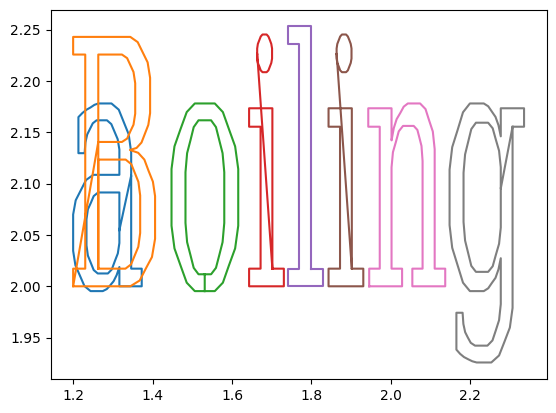

In [16]:
for i in a:
    plt.plot(i.points[:,0], i.points[:,1])
for i in b:
    plt.plot(i.points[:,0], i.points[:,1])

In [28]:
(24 / (-m) + c)

np.float64(1860.6022973377637)

In [29]:
import random
random.seed(0)
scene = TokenDecode(tree=node_tree)
random.seed(0)
scene.render()

[08/21/25 12:23:24] INFO     Animation 0 : Partial movie file written in                   ]8;id=441001;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=42450;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/3977891868_1914722975_1                         
                             987273652.mp4'                                                                        

                    INFO     Animation 1 : Partial movie file written in                   ]8;id=375441;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=611720;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_2093342896_2                         
                             450704490.mp4'                                                                        

                    INFO     Animation 2 : Partial movie file written in                   ]8;id=146039;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=295528;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_3500693530_2                         
                             70041736.mp4'                                                                         

[08/21/25 12:23:25] INFO     Animation 3 : Partial movie file written in                   ]8;id=838234;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=262674;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1914722975_3                         
                             853969878.mp4'                                                                        

                    INFO     Animation 4 : Partial movie file written in                   ]8;id=945989;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=154100;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_3663801256_1                         
                             310906820.mp4'                                                                        

[08/21/25 12:23:26] INFO     Animation 5 : Partial movie file written in                   ]8;id=942500;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=891786;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1348583704_5                         
                             54207670.mp4'                                                                         

                    INFO     Animation 6 : Partial movie file written in                   ]8;id=105592;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=370977;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_4079250704_3                         
                             258622375.mp4'                                                                        

[08/21/25 12:23:27] INFO     Animation 7 : Partial movie file written in                   ]8;id=957361;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=214410;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_3958234698_4                         
                             245239885.mp4'                                                                        

                    INFO     Animation 8 : Using cached data (hash :                           ]8;id=546678;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=273145;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py#89\89]8;;\
                             2852726489_825620620_3282659717)                                                      

                    INFO     Animation 9 : Partial movie file written in                   ]8;id=960489;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=14723;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_884610985_40                         
                             2444055.mp4'                                                                          

                    INFO     Animation 10 : Partial movie file written in                  ]8;id=744754;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=864912;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1914722975_1                         
                             140419100.mp4'                                                                        

[08/21/25 12:23:28] INFO     Animation 11 : Partial movie file written in                  ]8;id=765752;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=341001;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_982208722_23                         
                             99139830.mp4'                                                                         

                    INFO     Animation 12 : Partial movie file written in                  ]8;id=961564;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=595078;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1935032153_1                         
                             151391690.mp4'                                                                        

                    INFO     Animation 13 : Partial movie file written in                  ]8;id=842194;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=569366;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1914722975_3                         
                             462643333.mp4'                                                                        

[08/21/25 12:23:29] INFO     Animation 14 : Partial movie file written in                  ]8;id=978147;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=513054;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1882157950_6                         
                             76540531.mp4'                                                                         

[08/21/25 12:23:30] INFO     Animation 15 : Partial movie file written in                  ]8;id=740883;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=130873;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1847479458_1                         
                             449661811.mp4'                                                                        

                    INFO     Animation 16 : Using cached data (hash :                          ]8;id=566528;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=213072;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py#89\89]8;;\
                             2852726489_4079250704_2438553614)                                                     

                    INFO     Animation 17 : Partial movie file written in                  ]8;id=301630;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=466604;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1969365370_1                         
                             956441046.mp4'                                                                        

                    INFO     Animation 18 : Using cached data (hash :                          ]8;id=332447;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=603613;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py#89\89]8;;\
                             2852726489_379712821_1852124387)                                                      

                    INFO     Animation 19 : Partial movie file written in                  ]8;id=861370;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=195800;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_3768012392_3                         
                             680363213.mp4'                                                                        

                    INFO     Animation 20 : Partial movie file written in                  ]8;id=499678;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=72441;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1914722975_5                         
                             95362558.mp4'                                                                         

[08/21/25 12:23:31] INFO     Animation 21 : Partial movie file written in                  ]8;id=968235;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=40518;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1733809949_3                         
                             697253814.mp4'                                                                        

                    INFO     Animation 22 : Partial movie file written in                  ]8;id=967922;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=869647;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1048429696_4                         
                             241756033.mp4'                                                                        

                    INFO     Animation 23 : Partial movie file written in                  ]8;id=739543;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=550055;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1914722975_3                         
                             404938019.mp4'                                                                        

[08/21/25 12:23:32] INFO     Animation 24 : Partial movie file written in                  ]8;id=938516;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=712480;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_3219818962_2                         
                             605244846.mp4'                                                                        

                    INFO     Animation 25 : Partial movie file written in                  ]8;id=607854;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=288579;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_4079250704_2                         
                             020649441.mp4'                                                                        

                    INFO     Animation 26 : Partial movie file written in                  ]8;id=734239;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=961482;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1421419011_3                         
                             172702287.mp4'                                                                        

                    INFO     Animation 27 : Using cached data (hash :                          ]8;id=642549;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=120952;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py#89\89]8;;\
                             2852726489_4194564323_2129092109)                                                     

                    INFO     Animation 28 : Using cached data (hash :                          ]8;id=886128;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=199626;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py#89\89]8;;\
                             2852726489_1914722975_3801811183)                                                     

                    INFO     Animation 29 : Partial movie file written in                  ]8;id=122824;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=739595;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1914722975_8                         
                             85361147.mp4'                                                                         

[08/21/25 12:23:33] INFO     Animation 30 : Partial movie file written in                  ]8;id=855546;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=65213;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1530558224_1                         
                             208590531.mp4'                                                                        

                    INFO     Animation 31 : Partial movie file written in                  ]8;id=731560;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=229400;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_2479015950_3                         
                             490811444.mp4'                                                                        

                    INFO     Animation 32 : Partial movie file written in                  ]8;id=954220;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=982012;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1914722975_3                         
                             695845025.mp4'                                                                        

[08/21/25 12:23:34] INFO     Animation 33 : Partial movie file written in                  ]8;id=665845;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=197678;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_1970084601_4                         
                             52403025.mp4'                                                                         

                    INFO     Animation 34 : Partial movie file written in                  ]8;id=410212;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=95978;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_4079250704_9                         
                             00313705.mp4'                                                                         

                    INFO     Animation 35 : Partial movie file written in                  ]8;id=634917;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=22687;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_10030656_354                         
                             8785815.mp4'                                                                          

                    INFO     Animation 36 : Using cached data (hash :                          ]8;id=502512;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=220805;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/renderer/cairo_renderer.py#89\89]8;;\
                             2852726489_3780791654_2855623127)                                                     

[08/21/25 12:23:35] INFO     Animation 37 : Partial movie file written in                  ]8;id=712347;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=23889;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/partial_movie_files/TokenDecode/2852726489_3768012392_2                         
                             324944355.mp4'                                                                        

                    INFO     Combining to Movie file.                                      ]8;id=876507;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=272545;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#739\739]8;;\

                    INFO                                                                   ]8;id=315685;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=367309;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#886\886]8;;\
                             File ready at                                                                         
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/10                         
                             80p60/TokenDecode.mp4'                                                                
                                                                                                                   

                    INFO     The partial movie directory is full (> 100 files). Therefore, ]8;id=489822;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=41291;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#856\856]8;;\
                             manim has removed the 32 oldest file(s). You can change this                          
                             behaviour by changing max_files_cached in config.                                     

                    INFO     Rendered TokenDecode                                                      ]8;id=209039;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene.py\scene.py]8;;\:]8;id=272769;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene.py#255\255]8;;\
                             Played 38 animations                                                                  